In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras.layers import Dense, Flatten, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
import json

with open('sarcasm.json') as f:
    data = json.load(f)

sentences = []
labels = []

for row in data:
    sentences.append(row['headline'])
    labels.append(row['is_sarcastic'])

In [51]:
vocab_size = 1000
maxlen = 50
embedding_dim = 32
oov_token = '<OOV>'
padding = 'pre'
trunc = 'post'
training_size = 22000

In [52]:
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]
testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [53]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, padding=padding, truncating=trunc,maxlen=maxlen)
testing_seq = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(testing_seq, padding=padding, truncating=trunc, maxlen=maxlen)

In [54]:
padded = np.array(padded)
test_padded = np.array(test_padded)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [55]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    keras.layers.GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 32,817
Trainable params: 32,817
Non-trainable params: 0
_________________________________________________________________


In [56]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.9:
            self.stop_training = True
callbacks = myCallback()

In [57]:
epochs = 30
history = model.fit(padded, training_labels, epochs=epochs, validation_data=(test_padded, testing_labels),verbose=2, callbacks=[callbacks])

Epoch 1/30
688/688 - 1s - loss: 0.5628 - accuracy: 0.7009 - val_loss: 0.4245 - val_accuracy: 0.8051
Epoch 2/30
688/688 - 1s - loss: 0.3934 - accuracy: 0.8196 - val_loss: 0.3973 - val_accuracy: 0.8146
Epoch 3/30
688/688 - 1s - loss: 0.3707 - accuracy: 0.8308 - val_loss: 0.3949 - val_accuracy: 0.8178
Epoch 4/30
688/688 - 1s - loss: 0.3627 - accuracy: 0.8344 - val_loss: 0.3958 - val_accuracy: 0.8133
Epoch 5/30
688/688 - 1s - loss: 0.3601 - accuracy: 0.8348 - val_loss: 0.3981 - val_accuracy: 0.8178
Epoch 6/30
688/688 - 1s - loss: 0.3583 - accuracy: 0.8365 - val_loss: 0.4090 - val_accuracy: 0.8121
Epoch 7/30
688/688 - 1s - loss: 0.3567 - accuracy: 0.8361 - val_loss: 0.3998 - val_accuracy: 0.8127
Epoch 8/30
688/688 - 1s - loss: 0.3565 - accuracy: 0.8355 - val_loss: 0.4062 - val_accuracy: 0.8142
Epoch 9/30
688/688 - 1s - loss: 0.3555 - accuracy: 0.8389 - val_loss: 0.4016 - val_accuracy: 0.8178
Epoch 10/30
688/688 - 1s - loss: 0.3544 - accuracy: 0.8372 - val_loss: 0.4069 - val_accuracy: 0.8144

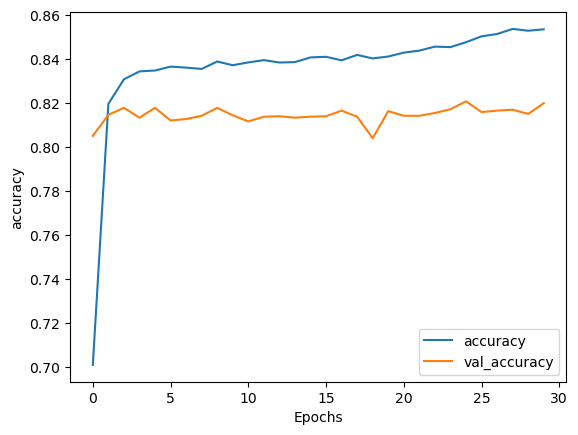

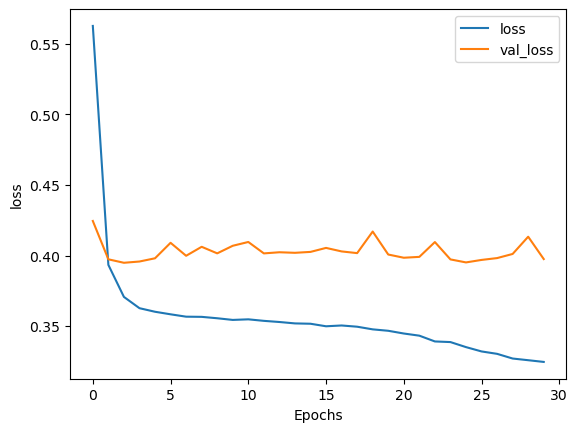

In [58]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [24]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(padded[2]))
print(training_sentences[2])
print(training_labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [26]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [29]:
test_sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
test_sequences = tokenizer.texts_to_sequences(test_sentence)
testing_padded = pad_sequences(test_sequences, maxlen=maxlen, padding=padding, truncating=trunc)
print(model.predict(testing_padded))

[[8.9252448e-01]
 [1.5610744e-06]]


In [ ]:
imdb, info = tfds.load('imdb')